In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = '/content/data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 1s 0us/step


In [ ]:
np.array(tf.io.gfile.listdir(str(data_dir)))

array(['right', 'down', 'left', 'no', 'stop', 'yes', 'README.md', 'up',
       'go'], dtype='<U9')

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'down' 'left' 'no' 'stop' 'yes' 'up' 'go']


In [ ]:
commands 

array(['right', 'down', 'left', 'no', 'stop', 'yes', 'up', 'go'],
      dtype='<U9')

In [ ]:
commands

array(['right', 'down', 'left', 'no', 'stop', 'yes', 'up', 'go'],
      dtype='<U9')

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'/content/data/mini_speech_commands/yes/42beb5eb_nohash_1.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [ ]:
test_file = tf.io.read_file('/content/data/mini_speech_commands/down/004ae714_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

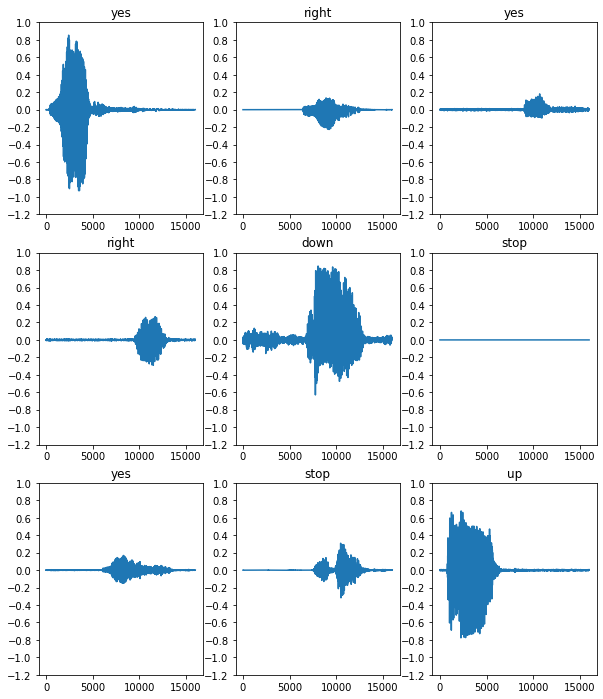

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

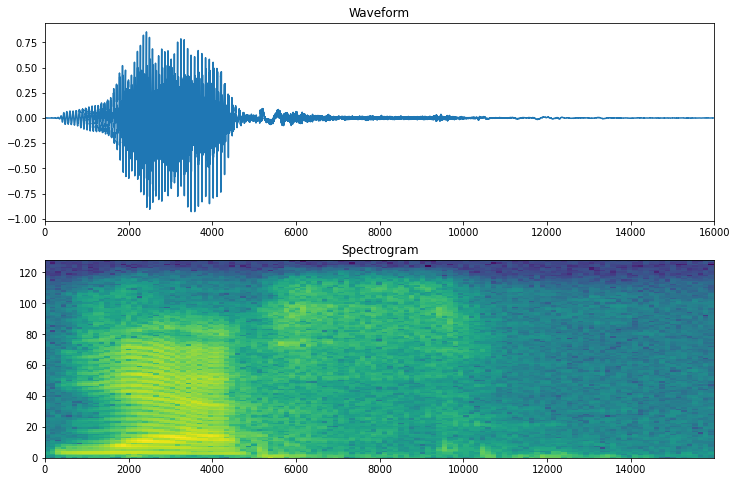

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

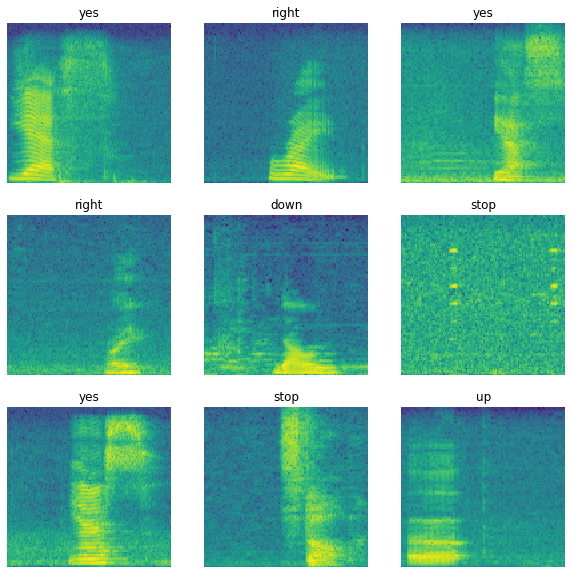

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spec, _ in spectrogram_ds.take(1):
  print(spec.shape)

(124, 129, 1)


In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
model_name = 'custom_speech.h5'
checkpoint = ModelCheckpoint(model_name, save_best_only=True, monitor='val_accuracy')
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=30,
              callbacks=[checkpoint,tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)],
              shuffle=True,
              verbose=1)

Epoch 1/30
100/100 [==============================] - 17s 77ms/step - loss: 1.7607 - accuracy: 0.3566 - val_loss: 1.3068 - val_accuracy: 0.5562
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 1.2132 - accuracy: 0.5673 - val_loss: 0.9121 - val_accuracy: 0.6900
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.9284 - accuracy: 0.6686 - val_loss: 0.7433 - val_accuracy: 0.7437
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.7866 - accuracy: 0.7212 - val_loss: 0.6482 - val_accuracy: 0.7738
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.6577 - accuracy: 0.7672 - val_loss: 0.5944 - val_accuracy: 0.7887
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.5767 - accuracy: 0.8008 - val_loss: 0.5632 - val_accuracy: 0.7912
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.5131 - accuracy: 0.8158 - val_loss: 0.5153 - val_accuracy: 0.8275
Epoc

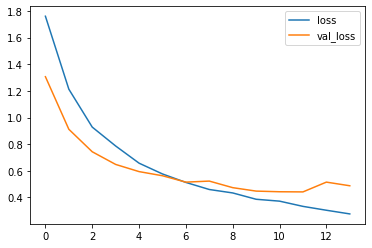

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())
  
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

print(test_audio.shape)

(800, 124, 129, 1)


In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


In [ ]:
from tensorflow.keras.losses import MSE
import tensorflow as tf


def fgsm_attack(model, image, label, eps):
  image = tf.cast(image, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    pred = model(image)
    loss = MSE(label, pred)
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)
    adversary = (image + (signedGrad * eps)).numpy()
    return adversary
  

In [ ]:
model.save("/content/drive/MyDrive/speech_adversary/model_custom")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech_adversary/model_custom/assets


In [ ]:
for audio, label in test_ds:
  y = np.expand_dims(audio, axis=0)
  print(y.shape)
  label_pred = print(np.argmax(model(y)))

(1, 124, 129, 1)
3
(1, 124, 129, 1)
1
(1, 124, 129, 1)
7
(1, 124, 129, 1)
2
(1, 124, 129, 1)
4
(1, 124, 129, 1)
3
(1, 124, 129, 1)
0
(1, 124, 129, 1)
5
(1, 124, 129, 1)
3
(1, 124, 129, 1)
5
(1, 124, 129, 1)
4
(1, 124, 129, 1)
1
(1, 124, 129, 1)
6
(1, 124, 129, 1)
7
(1, 124, 129, 1)
3
(1, 124, 129, 1)
1
(1, 124, 129, 1)
7
(1, 124, 129, 1)
3
(1, 124, 129, 1)
6
(1, 124, 129, 1)
2
(1, 124, 129, 1)
7
(1, 124, 129, 1)
1
(1, 124, 129, 1)
7
(1, 124, 129, 1)
1
(1, 124, 129, 1)
4
(1, 124, 129, 1)
4
(1, 124, 129, 1)
2
(1, 124, 129, 1)
4
(1, 124, 129, 1)
7
(1, 124, 129, 1)
2
(1, 124, 129, 1)
6
(1, 124, 129, 1)
5
(1, 124, 129, 1)
3
(1, 124, 129, 1)
7
(1, 124, 129, 1)
5
(1, 124, 129, 1)
6
(1, 124, 129, 1)
2
(1, 124, 129, 1)
6
(1, 124, 129, 1)
6
(1, 124, 129, 1)
7
(1, 124, 129, 1)
2
(1, 124, 129, 1)
2
(1, 124, 129, 1)
5
(1, 124, 129, 1)
0
(1, 124, 129, 1)
4
(1, 124, 129, 1)
2
(1, 124, 129, 1)
7
(1, 124, 129, 1)
7
(1, 124, 129, 1)
6
(1, 124, 129, 1)
4
(1, 124, 129, 1)
3
(1, 124, 129, 1)
5
(1, 124, 129

In [93]:

def fgsm_attack(model, image, label, eps):

  image = tf.cast(image, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    pred = model(image)
    loss = MSE(label, pred)
    print(loss)
  gradient = tape.gradient(loss, image)
  signedGrad = tf.sign(gradient)
  adversary = (image + (signedGrad * eps)).numpy()
  return adversary


In [135]:

def pgd_attack(model, image, label, alpha, eps):
  image = tf.cast(image, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    pred = model(image)
    print(pred)
    print(label)
    loss = tf.keras.losses.CategoricalCrossentropy()(label, pred) 
  gradient = tape.gradient(loss, image)
  signedGrad = tf.sign(gradient)
  adversary = (image + (signedGrad * alpha)).numpy()
  adversary = tf.clip_by_value(adversary, image-eps, image+eps)
  return adversary


In [94]:
actual_labels=[]
predicted_labels = []
for audio, label in test_ds:
  actual_label = label.numpy()
  predicted_label = np.argmax(model(np.expand_dims(audio, axis = 0)))
  print("actual_label", label.numpy())
  print("predicted_label", np.argmax(model(np.expand_dims(audio, axis = 0))))
  audio = np.expand_dims(audio, axis = 0)
  audio= tf.cast(audio, tf.float32)
  print("predicted_label", np.argmax(model(audio)))
  actual_labels.append(actual_label)
  predicted_labels.append(predicted_label)

actual_label 3
predicted_label 3
predicted_label 3
actual_label 1
predicted_label 1
predicted_label 1
actual_label 7
predicted_label 7
predicted_label 7
actual_label 2
predicted_label 2
predicted_label 2
actual_label 4
predicted_label 4
predicted_label 4
actual_label 1
predicted_label 3
predicted_label 3
actual_label 0
predicted_label 0
predicted_label 0
actual_label 5
predicted_label 5
predicted_label 5
actual_label 3
predicted_label 3
predicted_label 3
actual_label 5
predicted_label 5
predicted_label 5
actual_label 4
predicted_label 4
predicted_label 4
actual_label 1
predicted_label 1
predicted_label 1
actual_label 7
predicted_label 6
predicted_label 6
actual_label 7
predicted_label 7
predicted_label 7
actual_label 3
predicted_label 3
predicted_label 3
actual_label 1
predicted_label 1
predicted_label 1
actual_label 1
predicted_label 7
predicted_label 7
actual_label 3
predicted_label 3
predicted_label 3
actual_label 6
predicted_label 6
predicted_label 6
actual_label 2
predicted_label 

In [77]:
loss = MSE(actual_labels, predicted_labels)

In [78]:
 gradient = tape.gradient(loss, a)

tf.Tensor(2, shape=(), dtype=int32)


In [103]:
count = 0
for audio, label in test_ds:
  audioLabel = label.numpy()
  audio_mod = np.expand_dims(audio, axis = 0)
  audioPred = np.argmax(model(audio_mod))
  adversary = fgsm_attack(model, audio_mod, audioLabel, eps=0.2)
  adversaryPred = np.argmax(model(adversary))
  print("model_pred", audioPred)
  print("adversaryPred", adversaryPred)
  if audioPred == adversaryPred:
    count += 1


tf.Tensor([37.029915], shape=(1,), dtype=float32)
model_pred 3
adversaryPred 3
tf.Tensor([225.62454], shape=(1,), dtype=float32)
model_pred 1
adversaryPred 1
tf.Tensor([144.65617], shape=(1,), dtype=float32)
model_pred 7
adversaryPred 7
tf.Tensor([52.622612], shape=(1,), dtype=float32)
model_pred 2
adversaryPred 2
tf.Tensor([65.35695], shape=(1,), dtype=float32)
model_pred 4
adversaryPred 4
tf.Tensor([5.699067], shape=(1,), dtype=float32)
model_pred 3
adversaryPred 1
tf.Tensor([8.6189165], shape=(1,), dtype=float32)
model_pred 0
adversaryPred 0
tf.Tensor([232.14903], shape=(1,), dtype=float32)
model_pred 5
adversaryPred 5
tf.Tensor([45.772026], shape=(1,), dtype=float32)
model_pred 3
adversaryPred 3
tf.Tensor([176.98373], shape=(1,), dtype=float32)
model_pred 5
adversaryPred 5
tf.Tensor([88.97119], shape=(1,), dtype=float32)
model_pred 4
adversaryPred 4
tf.Tensor([35.040646], shape=(1,), dtype=float32)
model_pred 1
adversaryPred 4
tf.Tensor([55.785767], shape=(1,), dtype=float32)
model

In [98]:
print(count)

689


In [99]:
print(len(test_ds))

800


for pgd attack

In [114]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

In [128]:
test_labels
onehot_encoded = onehot_encoder.fit_transform(test_labels.reshape(-1,1))

In [139]:
count = 0
for audio,label in zip(test_audio,onehot_encoded) :
  
  audioLabel =[label]
  print(audioLabel)
  audio_mod = np.expand_dims(audio, axis = 0)
  audioPred = np.argmax(model(audio_mod))
  print(audioPred)
  adversary = pgd_attack(model, audio_mod, audioLabel, alpha = 2, eps = 2)
  adversaryPred = np.argmax(model(adversary))
  print("model_pred", audioPred)
  print("adversaryPred", adversaryPred)
  if audioPred == adversaryPred:
    count += 1


Streaming output truncated to the last 5000 lines.
[array([0., 1., 0., 0., 0., 0., 0., 0.])]
1
tf.Tensor(
[[-16.176369   15.106662  -16.73319     7.5589876  -1.3214666 -10.432053
  -13.843481    2.0109475]], shape=(1, 8), dtype=float32)
[array([0., 1., 0., 0., 0., 0., 0., 0.])]
model_pred 1
adversaryPred 1
[array([0., 1., 0., 0., 0., 0., 0., 0.])]
4
tf.Tensor(
[[-10.9012985    0.13818403   0.4858553    0.13144772   2.5491626
   -2.147712    -0.016679    -1.1398115 ]], shape=(1, 8), dtype=float32)
[array([0., 1., 0., 0., 0., 0., 0., 0.])]
model_pred 4
adversaryPred 4
[array([0., 0., 0., 0., 0., 0., 0., 1.])]
7
tf.Tensor(
[[-7.0164995 -1.8882622 -5.3447943  3.6389449 -4.6711693 -5.9991026
  -0.8684118  4.2199397]], shape=(1, 8), dtype=float32)
[array([0., 0., 0., 0., 0., 0., 0., 1.])]
model_pred 7
adversaryPred 7
[array([0., 0., 1., 0., 0., 0., 0., 0.])]
2
tf.Tensor(
[[ -0.45583785 -10.817628    10.36906     -3.1191914   -9.134207
    6.7339644   -4.599297    -6.9842997 ]], shape=(1, 8),

In [140]:
print(count)

775


In [141]:
print(len(test_ds))

800
